<a href="https://colab.research.google.com/github/AlexanderEM-git/TDS3/blob/main/FinalProject_TS3_RadioML_2023_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

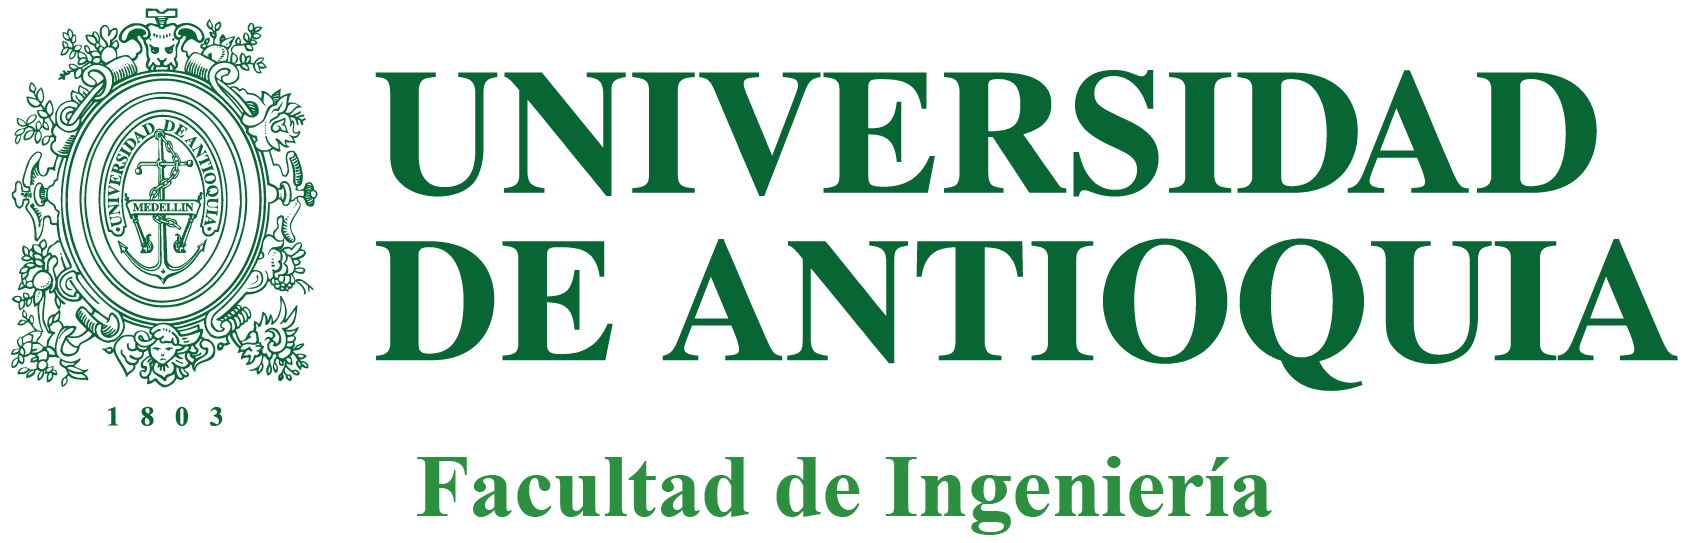

---
- **Asignatura:** Tratamiento de Señales III
- **Profesor:** Hernán Felipe García Arias
- **Ingeniería de Telecomunicaciones**

**Estudiantes:**
*   Alexander Espinosa Montoya.
*   Jose Daniel Rivera.

**UdeA**
**2023-2**

---

## Reconocimiento de modulación: conjunto de datos Radio Machine Learning 2016.10a

Más información sobre este método de clasificación se puede encontrar en
https://arxiv.org/abs/1602.04105

Más información sobre el conjunto de datos RML2016.10a se puede encontrar en
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Por favor, cita trabajos derivados.

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

Para ejecutar este ejemplo, deberá descargar o generar el conjunto de datos RML2016.10a (https://radioml.com/datasets/)
También necesitarás Keras instalado con el backend de Theano o Tensor Flow funcionando!

##Proyecto Final: Reconocimiento de Modulación Utilizando Redes Neuronales Convolucionales (CNN) con Base de Datos de RT

**Objetivo:**
- El objetivo de este proyecto final es diseñar e implementar un sistema de reconocimiento de modulación utilizando Redes Neuronales Convolucionales (CNN). El proyecto implicará la construcción de un modelo robusto de CNN capaz de clasificar con precisión diferentes esquemas de modulación presentes en la base de datos proporcionada (RadioML2016). El reconocimiento de modulación es una tarea crucial en sistemas de comunicación inalámbrica, y tu implementación contribuirá al avance del procesamiento de señales en comunicaciones.

**Conjunto de Datos:**
- Se proporcionará un conjunto de datos (Base de Datos RadioML2016) que contiene muestras de señales con varios esquemas de modulación. El conjunto de datos está dividido en conjuntos de entrenamiento y prueba. Es esencial preprocesar los datos de manera adecuada para alimentarlos al modelo de CNN.

*Este proyecto final no solo probará tu comprensión del reconocimiento de modulación y las CNN, sino también tu capacidad para aplicar conceptos de aprendizaje automático a desafíos de procesamiento de señales del mundo real.*

¡Buena suerte!







-

In [ ]:
import os,random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, sys
%matplotlib inline

## Keras
[Keras](https://keras.io/) es una abstracción en Python que te permite definir una red neuronal y automáticamente codificarla para bibliotecas de aprendizaje profundo (actualmente DeepLearning4j, TensorFlow y Theano). Simplemente le indicas a Keras cuántas capas tiene el modelo de la red y defines cómo son esas capas. Keras se encarga de convertirlo en algo que TensorFlow y Theano pueden utilizar. Por lo tanto, es ideal para el desarrollo rápido y experimentación con redes neuronales. Puedes construir rápidamente cosas y ajustar rápidamente las redes neuronales.

In [ ]:
from tensorflow import keras
from keras.utils import to_categorical
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
#from tensorflow.keras.optimizers import adam

#1. Preprocesamiento de Datos:
Carga y explora el conjunto de datos para entender su estructura y características. Preprocesa los datos, incluyendo normalización, cambio de tamaño y cualquier otro paso necesario para prepararlos para la entrada en la CNN.


In [ ]:
#Descarga de datos de datos
!gdown '1cKaq0v7TxyJmmDizZfV-BwUESr5-GaWP'

Downloading...
From: https://drive.google.com/uc?id=1cKaq0v7TxyJmmDizZfV-BwUESr5-GaWP
To: /content/RML2016.10a_dict.pkl
100% 641M/641M [00:08<00:00, 71.5MB/s]


## Configuración del Conjunto de Datos

O'Shea, Corgan y Clancy generaron un conjunto de datos simulado utilizando [GNU Radio](http://gnuradio.org). Se guarda como un archivo Pickle. Este es simplemente un archivo binario que se puede leer en Python (es un diccionario, similar a un archivo JSON).

Existen otros archivos de datos que puedes utilizar para entrenar y probar el modelo en el sitio web [radioml.com](https://radioml.com/datasets/radioml-2016-10-dataset/). El archivo Python para crear el conjunto de datos se encuentra [aquí](https://github.com/radioML/dataset/blob/master/generate_RML2016.10a.py).

In [ ]:
# Cragando el data set ...
#  You will need to seperately download (radioml.com) or generate this file
with open("RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding="latin1")

for key in Xd.keys():
    print(key)
    break

('QPSK', 2)


## Formato Pickle

Los datos que se guardaron contenían **un gran arreglo de diccionarios de Python**.

Las claves del diccionario eran las combinaciones de tipo de [modulación](https://en.wikipedia.org/wiki/Phase-shift_keying) y relaciones señal-ruido (SNR) que fueron simuladas por GNU Radio para producir los datos.

Hay 11 esquemas de modulación: 8 digitales y 3 analógicos.

Se agregó ruido blanco gaussiano a cada señal de manera proporcional a la potencia de la señal.

Por ejemplo, una señal modulada [BPSK](https://en.wikipedia.org/wiki/Phase-shift_keying#Binary_phase-shift_keying_.28BPSK.29) se simuló con relaciones señal-ruido (SNR) de -20 dB, -18 dB, -16 dB, hasta 18 dB.

Para un SNR de 0, la señal BPSK tendría la misma potencia total que el ruido gaussiano. Para SNR menores a 0, la señal BPSK sería abrumada por el ruido. En otras palabras, sería imposible para un humano identificar la modulación para esos SNR.

$$ \text{SNR en decibelios} = 10 \times \log \left ( \frac{\text{potencia de la señal}}{\text{potencia del ruido}} \right ) $$

In [ ]:
# Obtener una lista de todas las modulaciones presentes en las claves del diccionario
mods = sorted(list(set(map(lambda x: x[0], Xd.keys()))))

# Obtener una lista de todas las relaciones señal-ruido (snr) presentes en las claves del diccionario
snrs = sorted(list(set(map(lambda x: x[1], Xd.keys()))))

In [ ]:
print('Modulaciones presentes en el dataset: \n {} \n'.format(mods))
print('relaciones señal-ruido (snr) presentes en el dataset: \n {} \n'.format(snrs))

Modulaciones presentes en el dataset: 
 ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM'] 

relaciones señal-ruido (snr) presentes en el dataset: 
 [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18] 



### Señales de Radiofrecuencia (RF)

Una vez que hemos especificado la clave del diccionario (por ejemplo, ['QAM64', 4] para la modulación QAM64 a 4 dB SNR), nos quedará la siguiente matriz.

In [ ]:
np.shape(Xd['QAM64', 4])

(1000, 2, 128)

La salida (1000, 2, 128) indica que **Xd['QAM64', 4]** tiene una forma (shape) **tridimensional**.

+ La primera dimensión representa las 1000 ventanas muestreadas (cada ventana tiene las 128 muestras de I y Q).

+ La segunda dimensión representa las 2 componentes ([I y Q](https://youtu.be/h_7d-m1ehoY)) de la señal de RF.

+ La tercera dimensión representa las 128 muestras en el tiempo (1 MHz, por lo que 1 $\mu$s por índice).


##Calculo de la señal original por medio de las componentes I y Q
$$\text{Portadora RF Modulada} = I \cos(2\pi ft) + Q \sin(2 \pi ft)$$

- \(I\) es la componente en fase (In-Phase),
- \(Q\) es la componente en cuadratura (Quadrature),
- \(f\) es la frecuencia de la portadora,
- \(t\) es el tiempo.

In [ ]:
'''
Calcula la señal de RF original a partir de las componentes I y Q.
I Amplitud de la fase y Q Amplitud de el 90° desplazada
'''
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 1e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

## Grafiquemos algunas señales de los datos

Elegiremos:
* Una 8PSK (con SNR a 18 dB)
* Una PAM4 (con SNR a 6 dB)
* Una BPSK (con SNR a 0 dB)
* Una QAM64 (con SNR a -12 dB)

Observa cómo la señal queda sepultada en el ruido a medida que disminuye la SNR.

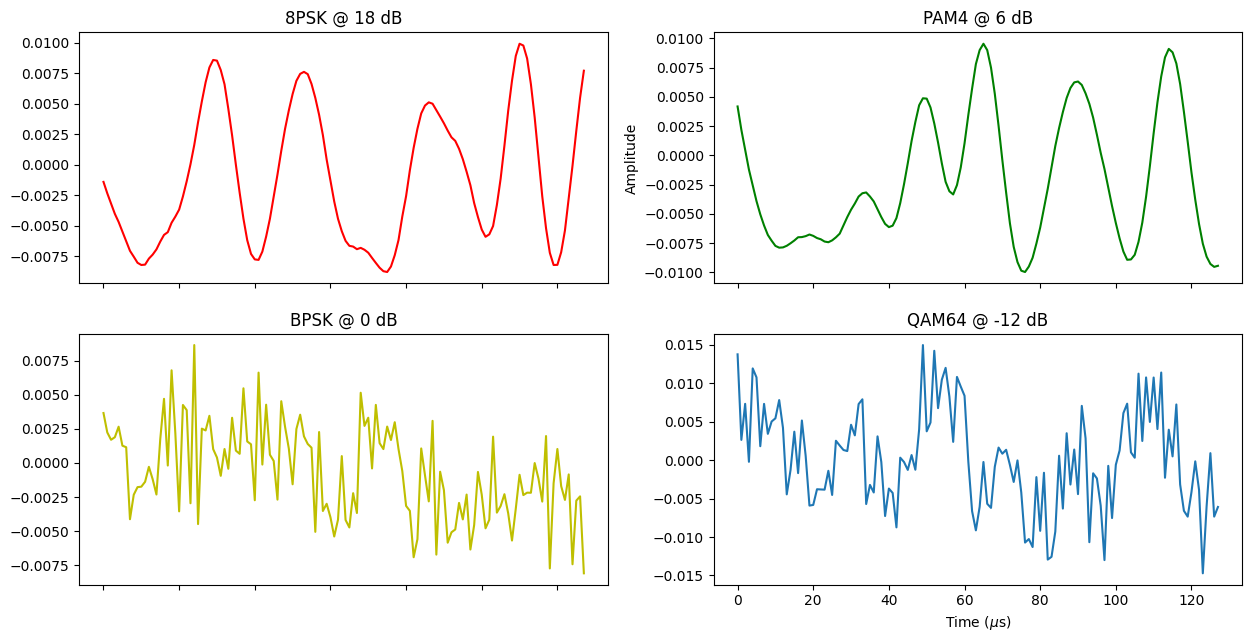

In [ ]:
# Plot some of the data
nFigs = 4

plt.figure(figsize=(15, 15))

ax1 = plt.subplot(nFigs, 2, 1);
plt.plot(reconstructSignal(Xd['8PSK', 18][2,:,:]), color='r');
plt.title('8PSK @ 18 dB')

ax2 = plt.subplot(nFigs, 2, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['8PSK', 18][99,:,:]), color='g');
plt.title('PAM4 @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 2, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['BPSK', 0][456,:,:]), color='y');
plt.title('BPSK @ 0 dB')

ax4 = plt.subplot(nFigs, 2, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['QAM64', -12][32,:,:]));
plt.title('QAM64 @ -12 dB')

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

### Una sola Modulacion diferentes SNR

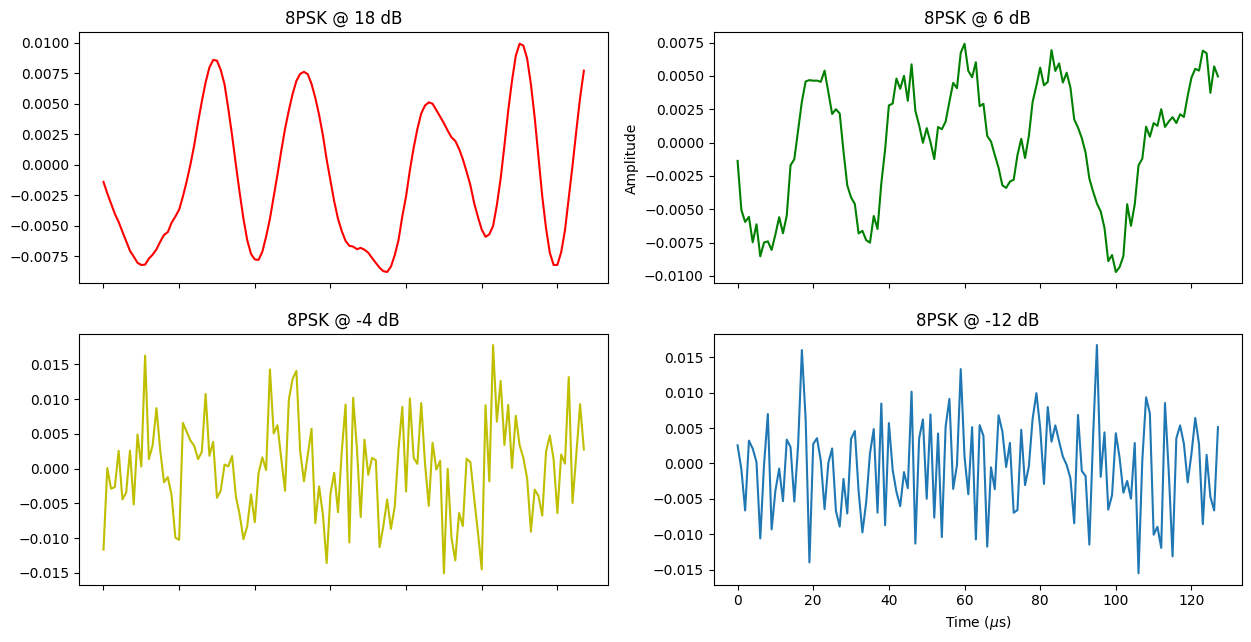

In [ ]:
# Plot some of the data
nFigs = 4

plt.figure(figsize=(15, 15))

ax1 = plt.subplot(nFigs, 2, 1);
plt.plot(reconstructSignal(Xd['8PSK', 18][2,:,:]), color='r');
plt.title('8PSK @ 18 dB')

ax2 = plt.subplot(nFigs, 2, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['8PSK', 6][2,:,:]), color='g');
plt.title('8PSK @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 2, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['8PSK', -4][2,:,:]), color='y');
plt.title('8PSK @ -4 dB')

ax4 = plt.subplot(nFigs, 2, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['8PSK', -12][2,:,:]));
plt.title('8PSK @ -12 dB')

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

### Ahora necesitamos concatenar todas las modulaciones, SNR, muestras, canales y puntos temporales en una matriz grande para pasarla a nuestra red neuronal.

In [ ]:
print('Modulaciones presentes en el dataset: \n {} \n'.format(len(mods)))
print('relaciones señal-ruido (snr) presentes en el dataset: \n {} \n'.format(len(snrs)))

Modulaciones presentes en el dataset: 
 11 

relaciones señal-ruido (snr) presentes en el dataset: 
 20 



***11x20x1000 = 220000 muestras***

Cada muestra es de tamaño 2 x 128. Los 2 representan los canales I y Q. Los 128 representan las 128 muestras temporales de la forma de onda (muestreadas a 1 MHz).


In [ ]:
#snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
np.shape(X)

(220000, 2, 128)

## Agregar la clase de ruido al Dataset

 agreguemos 2 canales de ruido gaussiano aleatorio para ver si podemos darle a la red la opción de elegir el ruido si no puede decidir entre las verdaderas modulaciones. Esto es básicamente una clasificación de "No sé".

In [ ]:
numNoiseSamples = 20000 # Agregamos 20,000 muestras de ruido gaussiano
for i in range(numNoiseSamples):
    lbl.append(['Noise', snrs[i%len(snrs)]])

mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X_ns = np.concatenate((X, X_noise))  # Agregamos el ruido al final de los datos
np.shape(X_ns)

(240000, 2, 128)

### Reajuste de Etiquetas.

El [One Hot Encode](https://en.wikipedia.org/wiki/One-hot) es necesario ya que la computadora no entiende letras; solo puede usar números. Entonces, no tiene idea de a qué se refiere '8PSK' o 'WBFM' y no tiene forma de entrenar un modelo para ajustarse a esas etiquetas.  

Podríamos asignar un número a cada modulación (por ejemplo, 1 = '8PSK', 2 = 'AM-DSB', 3 = 'PAM4', etc.). Sin embargo, la codificación one-hot facilita el cálculo de qué tan cercana está la salida de nuestra red neuronal (es decir, la predicción) al valor verdadero (esperado).

Para codificar one-hot, simplemente declaramos un vector que sea tan grande como el conjunto de modulaciones únicas. Entonces, si tenemos 11 modulaciones, declaramos un vector de tamaño 1 x 11. La matriz es 0 en todas partes, excepto en la modulación que se está representando. Por ejemplo,

+  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codifica '8PSK'
+  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codifica 'AM-DSB'
+  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codifica 'WBFM'

Entonces, el elemento más a la izquierda codifica '8PSK' y el más a la derecha codifica 'WBFM'. La posición es arbitraria, solo tiene que aplicarse consistentemente al conjunto de datos.

Una vez que hemos codificado one-hot, podremos comparar qué tan cerca está la salida de nuestra red neuronal (es decir, la predicción) de la verdadera modulación. Esta medida de "cercanía" se calcula típicamente mediante la entropía cruzada (de Shannon). Hay un [gran video aquí](https://www.youtube.com/watch?v=tRsSi_sqXjI).

$$ \text{entropía cruzada} = - \sum_i{L_i \log{S_i}}$$

donde
+ $i$ va desde 1 hasta el número de modulaciones
+ $L_i$ es la etiqueta one-hot para esa muestra en esa modulación
+ $S_i$ es la predicción de la red neuronal para esa muestra en esa modulación

Por ejemplo, si nuestra red neuronal predice 3 clases con las siguientes probabilidades:

$$\begin{bmatrix}0.2\\0.7\\0.1 \end{bmatrix}$$

y la muestra real tiene la codificación one-hot de:

$$\begin{bmatrix}0\\1\\0\end{bmatrix}$$

Entonces nuestra entropía cruzada es:  
$$ - [ 0 \times \log(0.2) + 1 \times \log(0.7) + 0 \times \log(0.1) ] = \log(0.7) = 0.155$$

Si la predicción es perfecta, entonces la entropía cruzada es $1 \times \log(1) = 0$

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lbl = np.array(lbl) # Convertir de lista a array de numpy (para mayor velocidad)

# Esto codificará las etiquetas en una matriz binaria.
# Esto se llama One-Hot.
# Cada elemento de la matriz es 1 o 0.
# La posición del elemento se refiere al tipo de modulación.
# Entonces, si hay 11 tipos de modulación, entonces la
# matriz tiene una longitud de 11.
# p. ej.,  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codifica '8PSK'
#          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codifica 'AM-DSB'
#          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codifica 'WBFM'
# Usaremos esto para comparar la salida de la red neuronal
# y ayudar a entrenar el modelo para dar el menor error (en este caso,
# el costo será la entropía cruzada).
y_encoded = LabelBinarizer().fit_transform(lbl[:, 0])

print(y_encoded.shape)

print(lbl[:10,1])
print(lbl[:10,0])
print(y_encoded[:10])

(240000, 12)
['-20' '-20' '-20' '-20' '-20' '-20' '-20' '-20' '-20' '-20']
['8PSK' '8PSK' '8PSK' '8PSK' '8PSK' '8PSK' '8PSK' '8PSK' '8PSK' '8PSK']
[[1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]]


## Dividir en un conjunto de entrenamiento y prueba

Es crucial que dividamos los datos en al menos 2 conjuntos. Un conjunto (llamado conjunto de entrenamiento) se utilizará para entrenar la red neuronal. Es decir, los pesos de la red neuronal se ajustarán para hacer la mejor predicción posible de los datos de entrenamiento. Sin embargo, si nos quedamos solo con eso, tendríamos un modelo que sería bueno para predecir cosas que ya conocía.

Queremos asegurarnos de que el modelo pueda predecir cosas que nunca ha visto antes. Así que guardamos algunos datos (generalmente alrededor de 1/4 a 1/3) para probar si la red neuronal entrenada puede ser igual de precisa en datos que nunca ha visto.

La mayoría de los conjuntos de herramientas decentes de aprendizaje automático contienen un método para dividir aleatoriamente sus datos en estos dos conjuntos. Normalmente usamos el de sklearn (train_test_split). Sin embargo, queremos hacer un seguimiento de los índices para que también podamos obtener las relaciones señal-ruido (SNR) al final. Así que simplemente usaremos una matriz aleatoria para dividir los dos grupos.

In [ ]:
# Separando los datos
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each

np.random.seed(2023) ## semilla para la particion
n_examples = X_ns.shape[0]
n_train = int(n_examples * 0.7)

# Now get a list of random indicies to sample for the training set
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# Testing set is whatever indicies are left over
test_idx = list(set(range(0,n_examples))-set(train_idx))

# Now split up the data by the random indicies
X_train = X_ns[train_idx]
X_test =  X_ns[test_idx]
Y_train = y_encoded[train_idx]
Y_test = y_encoded[test_idx]

In [ ]:
print('Training set is {}'.format(np.shape(X_train)))
print('Test set is {}'.format(np.shape(X_test)))

Training set is (168000, 2, 128)
Test set is (72000, 2, 128)


In [ ]:
in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
print(X_train.shape, in_shp)
classes = mods
print(classes)

(168000, 2, 128) [2, 128]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM', 'Noise']


In [ ]:
# Set up some params
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

#2. Arquitectura del Modelo CNN:
Diseña una arquitectura de CNN adecuada para el reconocimiento de modulación. Considera la forma de entrada, el número de capas, los tamaños de filtro y las funciones de activación. Implementa el modelo CNN utilizando un marco de aprendizaje profundo de tu elección (por ejemplo, TensorFlow, PyTorch, Keras).

## Construir el Modelo de Red Neuronal (NN)

Tu tarea aquí es codificar 2 arquitecturas de CNN para evaluar el reconocimiento de modulación utilizando enfoques de Aprendizaje Profundo.

In [ ]:
# Build CNN Neural Net model using tensorflow  --
#  - Reshape [N,2,128] to [N,2,128,1] on input
#  - Pass through 3 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

#Reshape,Dense,Dropout,Activation,Flatten
#GaussianNoise
#Convolution2D, MaxPooling2D, ZeroPadding2D

# Define el modelo
dr = 0.6 # dropout rate (%) = percentage of neurons to randomly lose each iteration
model = models.Sequential()  # Neural network is a set of sequential layers

# number of convolutional filters to use
nb_filters = [16,32,64]
# convolution kernel size
kernel_size = [(1,2),(1,4),(1,8)]
input_shape=(2, 128, 1)
# size of pooling area for max pooling
pool_size = (2, 2)


# 3 Capas Convolution2D
model.add(Reshape((2,128,1),input_shape=(2,128)))
model.add(Convolution2D(filters = nb_filters[0], kernel_size = kernel_size[0],strides = (1,2),padding='valid',activation='relu', name="conv1"))
model.add(Convolution2D(filters = nb_filters[1], kernel_size = kernel_size[1],strides = (1,2),activation='relu',name="conv2"))
model.add(Convolution2D(filters = nb_filters[2], kernel_size = kernel_size[2],strides = (1,2),activation='relu',name="conv3"))
#model.add(MaxPooling2D(pool_size=pool_size)) #reduce la dimensionalidad espacial de la representación y reduce el costo computacional
model.add(Flatten()) # Esto convierte la salida 2D en un vector 1D que puede ser conectado a capas densas

# 2 capas densas
model.add(Dense(units=256, activation='relu', name="Dense1"))
model.add(Dropout(dr))
model.add(Dense(units=128, activation='relu', name="Dense2"))
model.add(Dropout(dr))
model.add(Dense(len(classes), activation='softmax', name="Dense3"))

# Perform categorical cross entropy optimization
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 2, 128, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 2, 64, 16)         48        
                                                                 
 conv2 (Conv2D)              (None, 2, 31, 32)         2080      
                                                                 
 conv3 (Conv2D)              (None, 2, 12, 64)         16448     
                                                                 
 flatten_7 (Flatten)         (None, 1536)              0         
                                                                 
 Dense1 (Dense)              (None, 256)               393472    
                                                                 
 dropout_14 (Dropout)        (None, 256)              

3. Entrenamiento: Divide el conjunto de datos en conjuntos de entrenamiento y validación. Entrena el modelo de CNN utilizando el conjunto de entrenamiento, monitoreando y optimizando el rendimiento en el conjunto de validación. Experimenta con diferentes hiperparámetros para mejorar la precisión del modelo.
4. Evaluación: Evalúa el modelo entrenado en el conjunto de prueba para evaluar su rendimiento en el reconocimiento de esquemas de modulación. Calcula métricas relevantes como precisión, sensibilidad, recuperación y puntuación F1.
5. Análisis y Visualización: Proporciona visualizaciones de la pérdida y la precisión de entrenamiento/validación a lo largo de las épocas. Analiza la matriz de confusión para entender el rendimiento del modelo en diferentes esquemas de modulación.

# Entrenando el Modelo

Para entrenar el modelo, Usamos `ModelCheckpoint` y `EarlyStopping` para monitoriar el entrenamiento y evitar el sobre ajuste

In [ ]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = './'
modelWeightsFile = filepath + 'PESOS_TSIII.wts.h5'  # Save the model weights to this file

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(modelWeightsFile)

Epoch 1/100

Epoch 1: val_loss improved from inf to 2.14862, saving model to ./PESOS_TSIII.wts.h5
165/165 - 13s - loss: 2.3374 - accuracy: 0.1498 - val_loss: 2.1486 - val_accuracy: 0.2397 - 13s/epoch - 79ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 2.14862
165/165 - 2s - loss: 2.2940 - accuracy: 0.1734 - val_loss: 2.3225 - val_accuracy: 0.1373 - 2s/epoch - 10ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 2.14862
165/165 - 1s - loss: 2.3112 - accuracy: 0.1407 - val_loss: 2.2469 - val_accuracy: 0.1949 - 1s/epoch - 7ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 2.14862
165/165 - 1s - loss: 2.2086 - accuracy: 0.2025 - val_loss: 2.1697 - val_accuracy: 0.2145 - 1s/epoch - 8ms/step
Epoch 5/100

Epoch 5: val_loss improved from 2.14862 to 1.98667, saving model to ./PESOS_TSIII.wts.h5
165/165 - 1s - loss: 2.1057 - accuracy: 0.2469 - val_loss: 1.9867 - val_accuracy: 0.2871 - 1s/epoch - 9ms/step
Epoch 6/100

Epoch 6: val_loss improved from 1.98667 to 1.80412, saving model to ./PESOS_TSIII.wts.h5
165/165 - 2s - loss: 1.9913 - accuracy: 0.2909 - val_loss: 1.8041 - val_accuracy: 0.3427 - 2s/epoch - 11ms/step
Epoch 7/100

Epoch 7: val_loss improved from 1.80412 to 1.68026, saving

**Analisis**: En la época 86 se detuvo el entrenamiento ya que no hubo mejora, esto evita el sobre entrenamiento.

# Evaluacion y muestra del rendimiento del modelo

In [ ]:
from sklearn.metrics import classification_report

#X_test_reshaped = X_test.reshape(X_test.shape[0],2,128)

#Hago predicciones
y_probs = model.predict(X_test)
y_predict = np.argmax(y_probs, axis=1)

#Imprimo el reporte de clasificacion
print(classification_report(np.argmax(Y_test, axis=1), y_predict))

2250/2250 [==============================] - 4s 2ms/step
              precision    recall  f1-score   support

           0       0.45      0.51      0.48      6024
           1       0.54      0.72      0.61      5935
           2       0.26      0.97      0.41      6017
           3       0.85      0.57      0.69      6052
           4       0.77      0.60      0.67      5960
           5       0.83      0.63      0.72      6009
           6       1.00      1.00      1.00      6001
           7       0.94      0.60      0.73      6057
           8       0.48      0.02      0.04      5993
           9       0.51      0.67      0.58      5996
          10       0.77      0.27      0.40      5842
          11       0.90      0.16      0.27      6114

    accuracy                           0.56     72000
   macro avg       0.69      0.56      0.55     72000
weighted avg       0.69      0.56      0.55     72000



**Analisis**: podemos ver que en el reporte que en general el modelo tiene una precisión de 56%, algunas modulaciones tienen una mejor precisión que otras pero en general la precisión no es muy alta.

## Curvas de perdida

Las curvas de pérdidas nos muestran qué tan bien fue el entrenamiento. También nos permiten detectar el sobreentrenamiento del modelo. Si el modelo está sobreentrenado, es posible que no se generalice bien. A menudo, en un modelo sobreentrenado, la pérdida de entrenamiento (error) disminuirá continuamente mientras que la validación (error de prueba) disminuirá y luego comenzará a aumentar nuevamente con sucesivas épocas de entrenamiento.

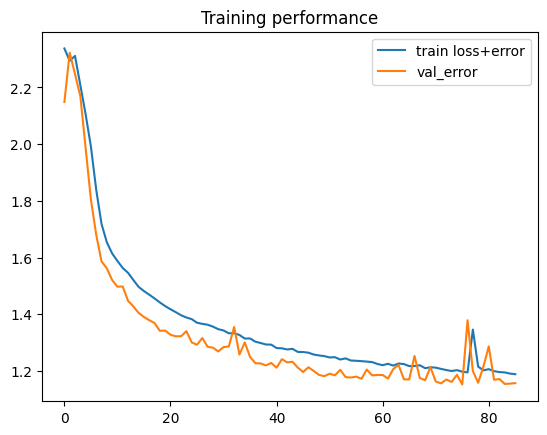

In [ ]:
# Show loss curves
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

**Analisis**: el modelo en las épocas iniciales no es muy eficiente, pero al ir avanzando en el entrenamiento se va estabilizando hasta llegar a la epoca 86 donde el Val error no mejora y tiende a ser constante, ahí se detiene para evitar el sobre entrenamiento.


# Matriz de Confusion

Una matriz de confusión es una excelente manera de ver dónde tuvo problemas el modelo (red neuronal). Traza el número de veces que el modelo predijo una modulación versus la modulación real (predicha versus verdadera).

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

71/71 [==============================] - 0s 3ms/step


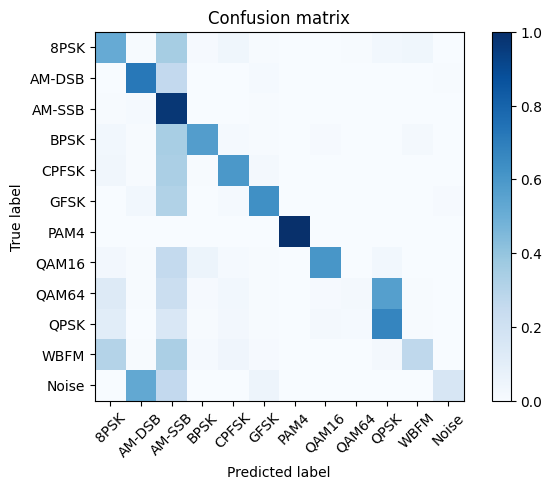

In [ ]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



**Analisis**: Podemos ver que el modelo en general pudo predecir más del 50% de las modulaciones de las señales, eso se puede ver en la intensidad de los colores en la diagonal principal, también vemos que el modelo tiene problemas con la modulación AM-SSB en gran medida, también 8PSK, AM-DSB y QPSK


Pleaes evaluate the model in terms of $SNR$ and their accuracy for each modulation (below is a a sample code to assess your models)

In [ ]:
lbl

array([['8PSK', '-20'],
       ['8PSK', '-20'],
       ['8PSK', '-20'],
       ...,
       ['Noise', '14'],
       ['Noise', '16'],
       ['Noise', '18']], dtype='<U21')

In [ ]:
# Extraer las etiquetas de SNR para los índices de prueba
test_SNRs = list(map(lambda x: int(lbl[x][1]), test_idx))
print(test_SNRs)
print(len(test_SNRs))

[-20, -20, -20, -20, 2, 2, -20, -20, -20, 2, 2, 2, 2, -20, 2, -20, 2, 2, -20, 2, -20, 2, -20, 2, -20, 2, 2, 2, 2, 2, -20, 2, 2, -20, 2, 2, -20, 2, 2, 2, 2, -20, -20, 2, 2, 2, 2, 2, 2, -20, -20, 2, 2, 2, 2, -20, 2, 2, -20, 2, 2, -20, 2, -20, 2, -20, -20, -20, 2, -20, -20, 2, 2, -20, 2, -20, 2, -20, 2, 2, -20, 2, 2, -20, 2, -20, -20, -20, 2, 2, 2, -20, 2, 2, 2, 2, 2, -20, 2, 2, -20, -20, -20, 2, -20, -20, -20, 2, 2, 2, -20, 2, -20, -20, -20, -20, -20, 2, -20, -20, 2, 2, -20, -20, 2, -20, 2, 2, -20, 2, 2, -20, 2, 2, 2, -20, -20, 2, -20, -20, -20, -20, 2, -20, -20, -20, 2, -20, 2, -20, 2, -20, 2, -20, -20, -20, 2, -20, -20, 2, -20, -20, -20, 2, -20, -20, -20, 2, -20, 2, 2, 2, -20, -20, 2, 2, -20, 2, -20, -20, -20, 2, -20, -20, 2, 2, 2, -20, 2, 2, -20, 2, -20, 2, 2, 2, -20, -20, 2, -20, 2, 2, -20, -20, -20, 2, 2, -20, 2, 2, 2, -20, 2, 2, -20, -20, -20, 2, 2, -20, 2, 2, 2, 2, -20, -20, 2, -20, -20, 2, -20, 2, -20, 2, -20, -20, 2, -20, 2, -20, 2, -20, 2, 2, -20, -20, -20, 2, -20, 2, 2, -20, -

115/115 [==============================] - 2s 17ms/step
Overall Accuracy for SNR -20: 0.16657534246575342
115/115 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -18: 0.1710239651416122
113/113 [==============================] - 2s 15ms/step
Overall Accuracy for SNR -16: 0.17009449694274598
111/111 [==============================] - 1s 5ms/step
Overall Accuracy for SNR -14: 0.17178259645170374
113/113 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -12: 0.19275442477876106
116/116 [==============================] - 1s 10ms/step
Overall Accuracy for SNR -10: 0.2562922868741543
113/113 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -8: 0.36846473029045645
112/112 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -6: 0.5231027723326799
115/115 [==============================] - 2s 18ms/step
Overall Accuracy for SNR -4: 0.6345996173817983
111/111 [==============================] - 2s 17ms/step
Ov

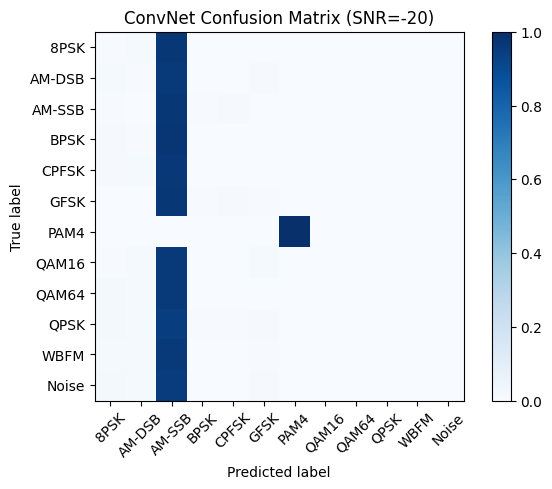

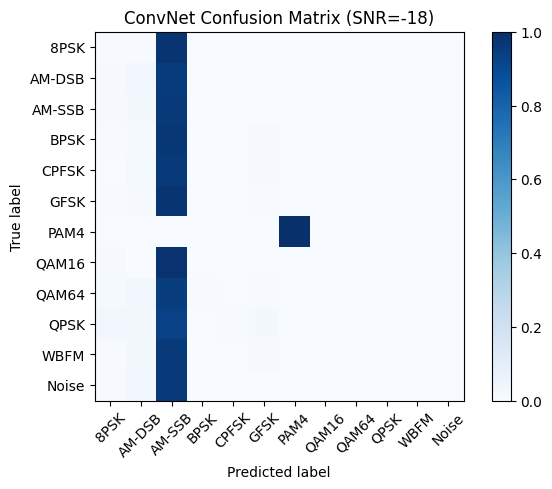

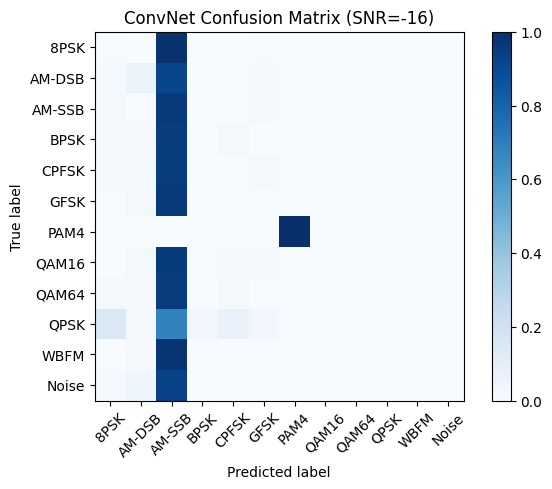

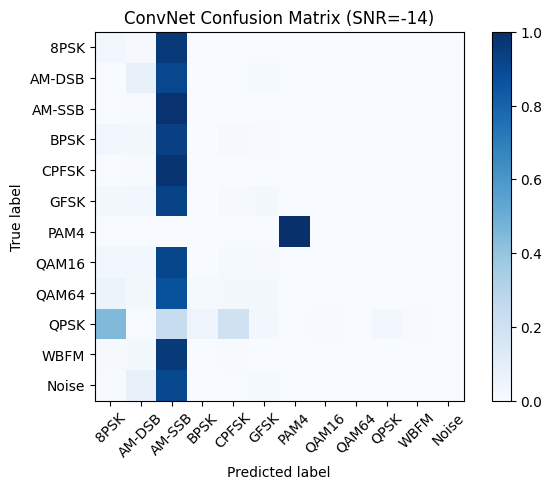

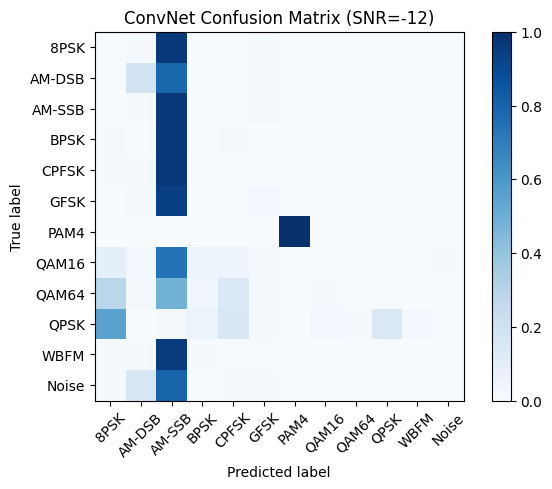

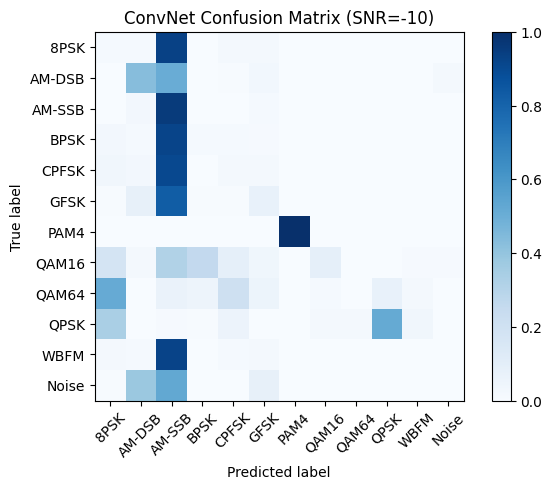

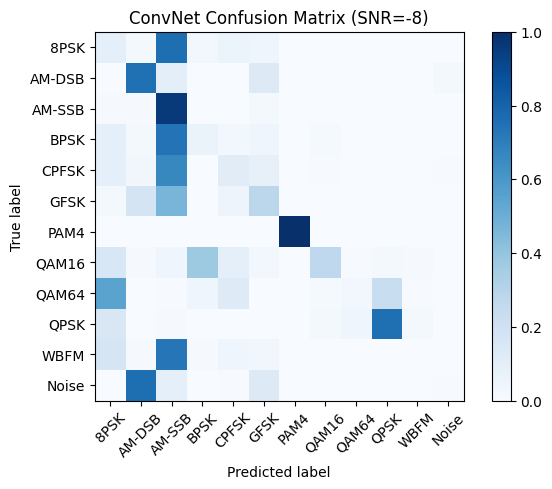

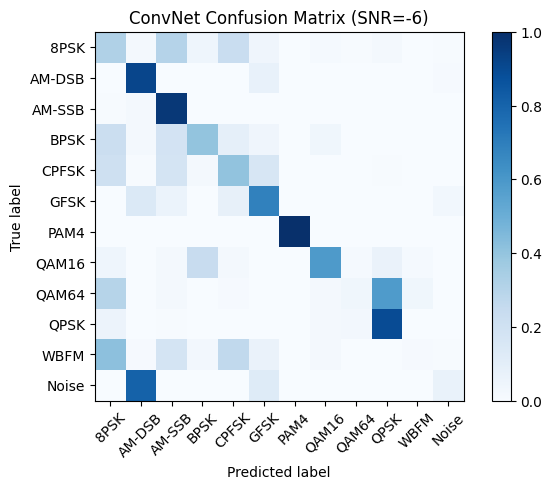

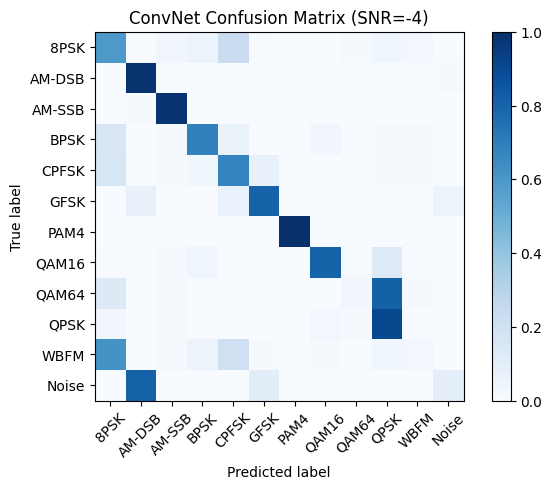

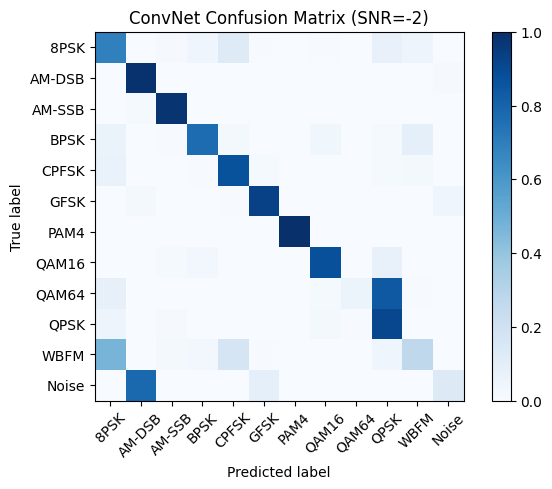

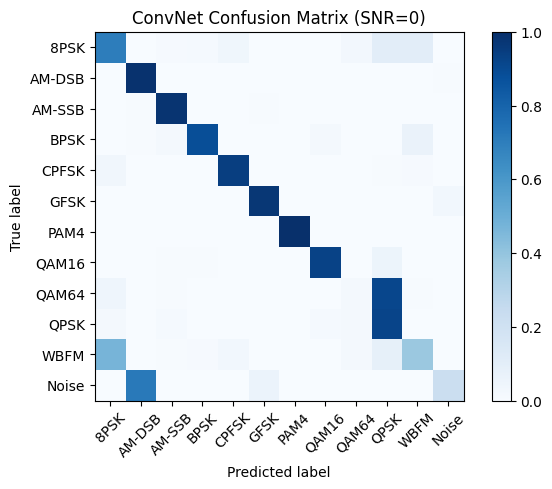

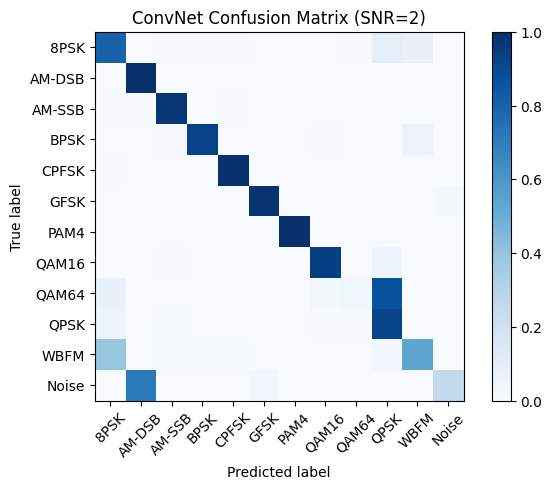

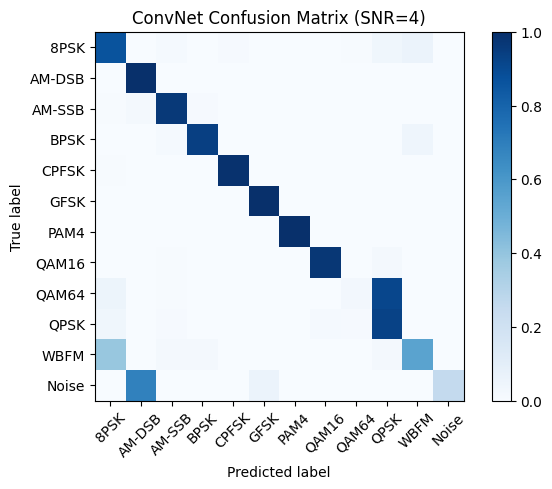

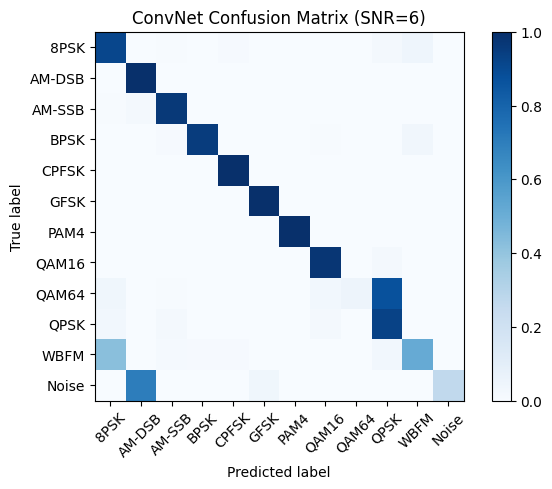

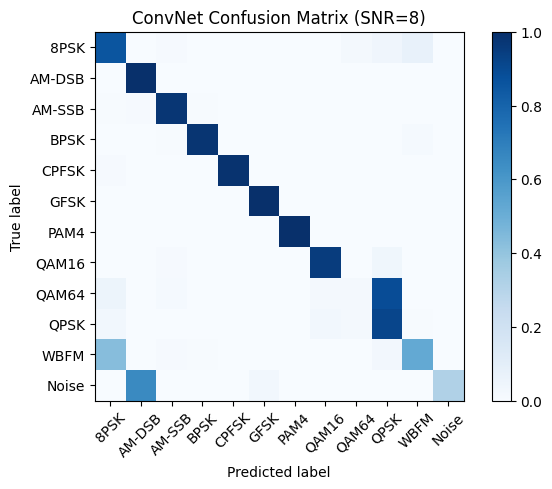

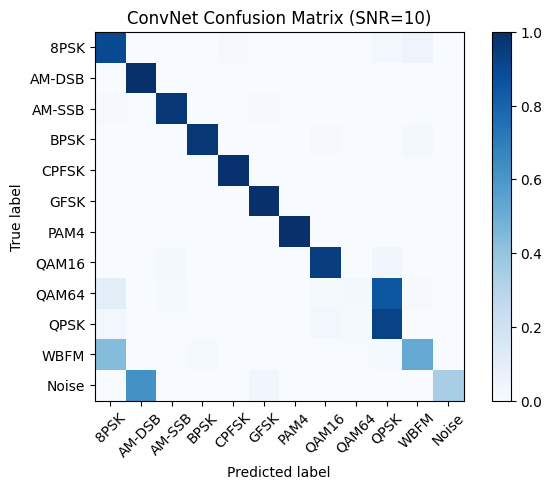

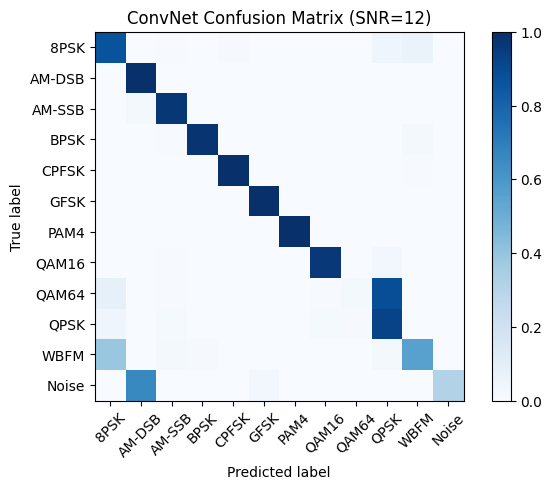

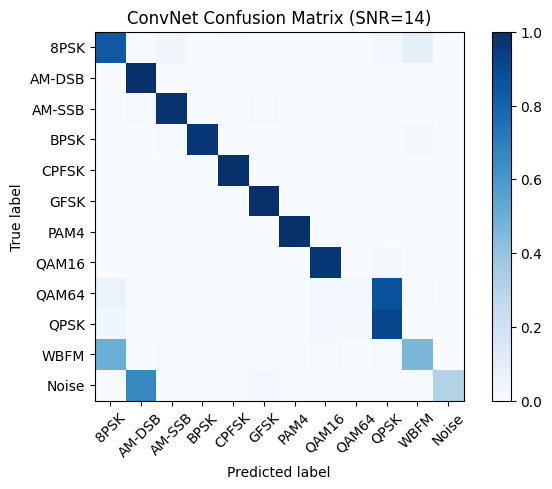

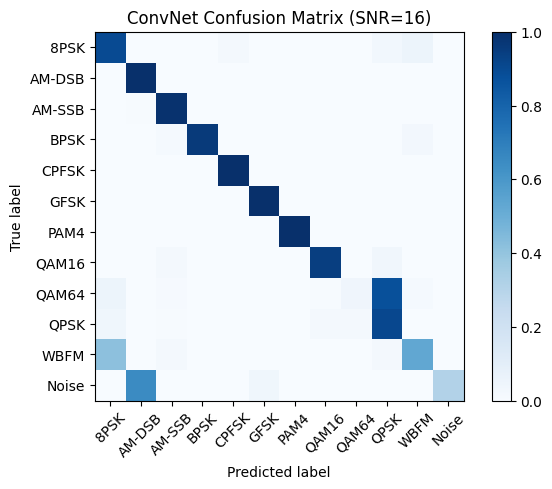

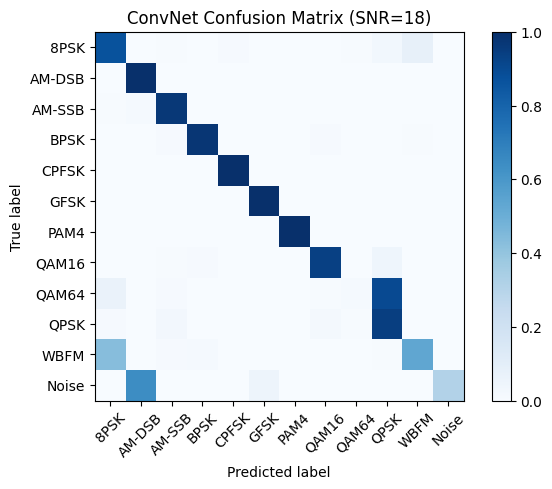

In [ ]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)


**Analisis**: Podemos ver que una baja SNR no permite al modelo determinar bien qué modulación es la que se está tratando,con una SNR de 4 el modelo es capaz de identificar bien a quién pertenece esa modulación en términos generales.


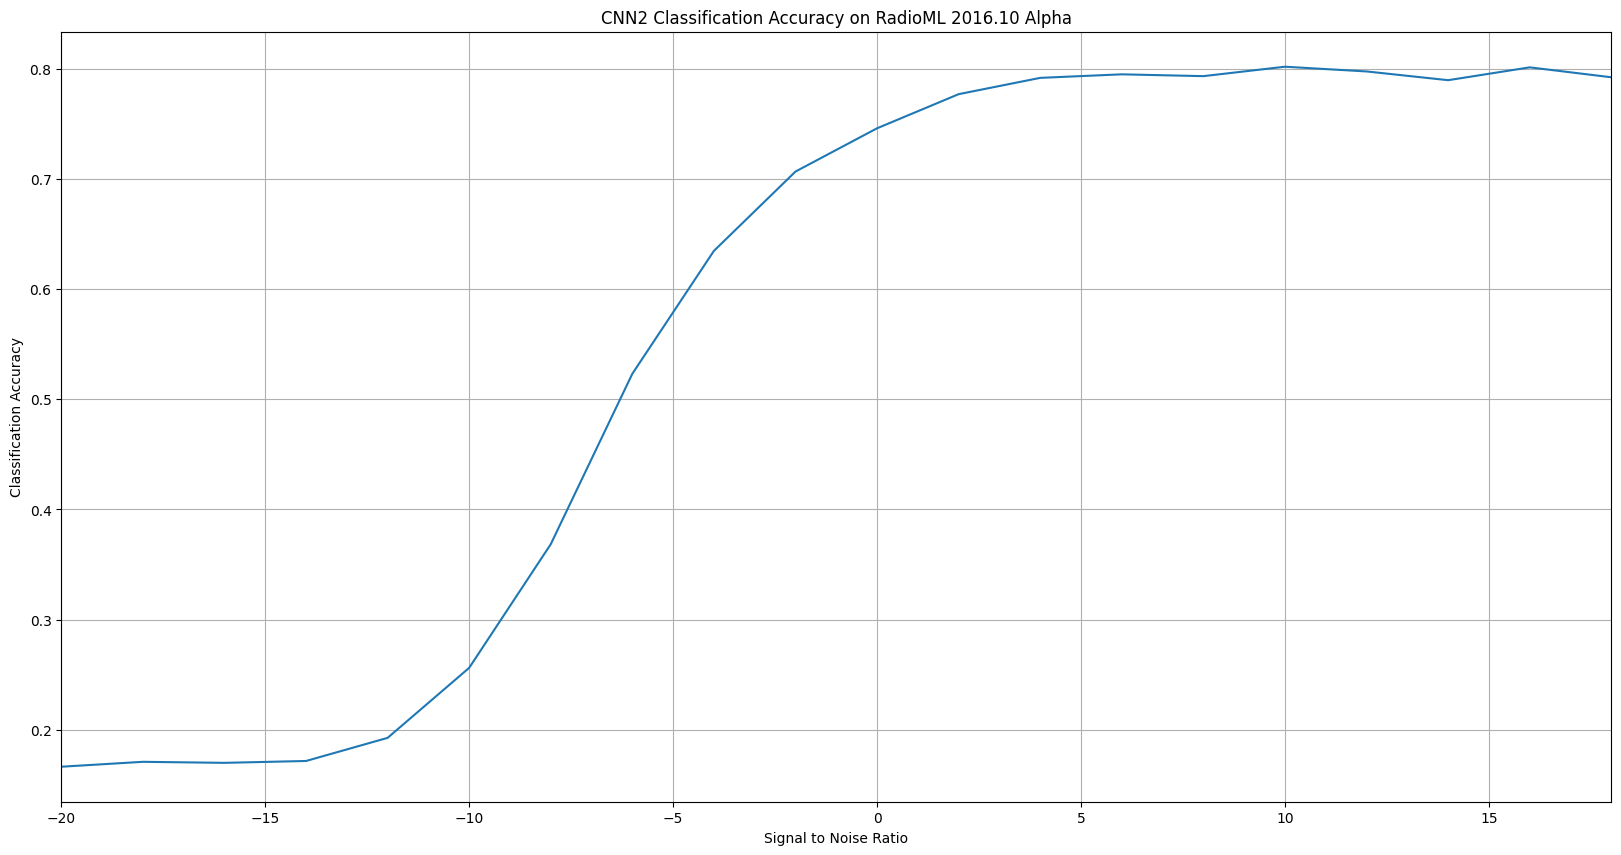

In [ ]:
# Plot accuracy curve
plt.figure(figsize=(20, 10))
plt.plot(snrs, list(map(lambda x: acc[x], snrs)));
plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha");
# Establecer los límites del eje x de -20 a 18
plt.xlim(-20, 18)
plt.grid()
plt.show()

#Conclusion

Tomando en cuenta que las señales al presentar una baja SNR son difíciles de identificar de forma visual de todas las que se encuentran el el dataset, es comprensible que el modelo se comporte bien con altas SNR, ya que la señal puede ser identificada hasta visualmente,  para mejorar este rendimiento es posible que sea necesario alimentar más el modelo, sea de tiempo, número de muestras y datos para mejorar el rendimiento.
